<CENTER>
</br>
<p><font size="6">  Go Board Detection </font></p>

</p>
</CENTER>



In this notebook, we're going to explain step by step how to detect a go board and represent it visually given a frame from a Go game recording.

We're going to use a custom trained Yolov8 model (see "Transfer learning YoloV8.ipynb") to detect stones, corners and empty intersections. We're then going to use the empty intersections to find the rest of the intersections by interpolating and finding the missing lines. We then create a map for the board and assign each stone to its position. 

Though some of the functions defined here may seem useless for most frames, they solve some errors in particular cases, which is important since the code is supposed to be used during a live stream of a go game, in which luminosity may vary and cause issues while detecting lines. Detection is not always perfect so we have to make sure we have all lines by the end of the algorithm, by adding any missing ones and making sure we don't have duplicates.

N.B: the position of the stones on the board isn't taken from an actual game and is purely arbitrary.

> 1. Fetching results from the model
> 2. Idenfiying, classifying, interpolating, cleaning and completing lines
> 3. Finding intersections and assinging stones
> 4. Creating sgf file and drawing the board

In [84]:
#imports
from sgfmill import sgf
import math
from sklearn.cluster import KMeans, DBSCAN
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

We start by loading our custom trained model and fetch results

In [71]:
frame = cv2.imread("a.jpg")

model = YOLO('model.pt')

results = model(frame)
annotated_frame = results[0].plot(labels=False, conf=False)



0: 480x800 54 black_stones, 1 board, 6 board_corners, 84 emptys, 27 empty_edges, 51 white_stones, 211.0ms
Speed: 7.0ms preprocess, 211.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)


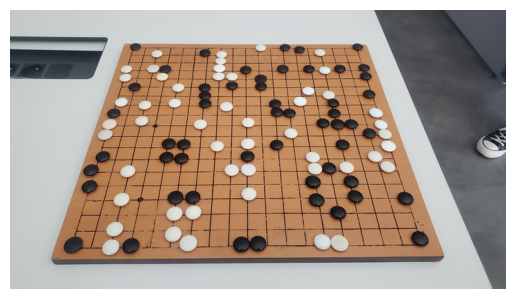

In [72]:
frame_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
annotated_frame_ = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_)
plt.axis('off')  
plt.show()

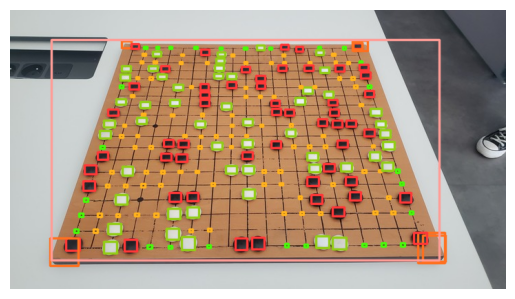

In [73]:
plt.imshow(annotated_frame_)
plt.axis('off')  
plt.show()

We fetch the corners, making sure we only take 4 of them by eliminating unecessary or false detections. We do that by first applying a non-max-suppression to calculate the best box out of a set of overlapping bounding boxes (on the same corner) based on their confidence levels.

Next, we eliminate corners that were fasly detected outside of the board.

Finally, we calculate the centers of the bounding boxes and sort them.

In [ ]:
def non_max_suppression(boxes, overlapThresh=0.5):
    """
    Apply non-maximum suppression to eliminate redundant bounding boxes.

    Args:
    -----------
    boxes : numpy.ndarray
            Array of bounding boxes with coordinates [x1, y1, x2, y2].
    overlapThresh : float, optional
                    Threshold for overlap to consider bounding boxes as redundant (default=0.5).

    Returns:
    --------
    numpy.ndarray
        Array of picked bounding boxes after non-maximum suppression.
    """
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [11]:
def are_corner_inside_box(corner_boxes, board_box):
    
    x1, y1, x2, y2 = board_box

    # Extract the coordinates of the squares
    square_x1 = corner_boxes[:, 0]
    square_y1 = corner_boxes[:, 1]
    square_x2 = corner_boxes[:, 2]
    square_y2 = corner_boxes[:, 3]

    # Check if any corner of the corner_boxes is inside the board_box
    condition = (
        ((square_x1 >= x1) & (square_x1 <= x2) & (square_y1 >= y1) & (square_y1 <= y2)) |
        ((square_x2 >= x1) & (square_x2 <= x2) & (square_y1 >= y1) & (square_y1 <= y2)) |
        ((square_x1 >= x1) & (square_x1 <= x2) & (square_y2 >= y1) & (square_y2 <= y2)) |
        ((square_x2 >= x1) & (square_x2 <= x2) & (square_y2 >= y1) & (square_y2 <= y2))
    )

    # Select corner_boxes that meet the condition
    return corner_boxes[condition]

In [12]:
def get_corners(results):    
    corner_boxes = np.array(results[0].boxes.xyxy[results[0].boxes.cls == 2])

    corner_boxes = non_max_suppression(corner_boxes)
    
    board_model_edges = results[0].boxes.xyxy[results[0].boxes.cls == 1][0]
    
    corner_boxes = are_corner_inside_box(corner_boxes, np.array(board_model_edges))

    if len(corner_boxes) != 4:
        raise Exception(f">>>>Incorrect number of corners! Detected {len(corner_boxes)} corners")

    corner_centers = ((corner_boxes[:,[0, 1]] + corner_boxes[:,[2, 3]])/2)
    # corner_centers = corner_centers
    
    corner_centers = corner_centers[corner_centers[:, 1].argsort()]
    
    upper = corner_centers[:2]
    lower = corner_centers[2:]
    
    upper = upper[upper[:, 0].argsort()]
    lower = lower[lower[:, 0].argsort()[::-1]]
    
    return np.concatenate((upper, lower)).astype(dtype=np.float32)

In [74]:
input_points = get_corners(results)

Let's visualise the final corners

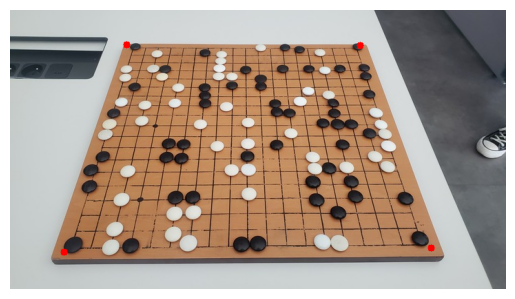

In [75]:
image = frame.copy()

for point in input_points:
    cv2.circle(image, tuple(point.astype(int)), 5, (0, 0, 255), -1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Given the corners' positions, we can now calculate the perspective matrix and get the transformed image. 

In [76]:
output_edge = 600
output_points = np.array([[0, 0], [output_edge, 0], [output_edge, output_edge], [0, output_edge]], dtype=np.float32)

perspective_matrix = cv2.getPerspectiveTransform(input_points, output_points)
transformed_image = cv2.warpPerspective(frame, perspective_matrix, (output_edge, output_edge))

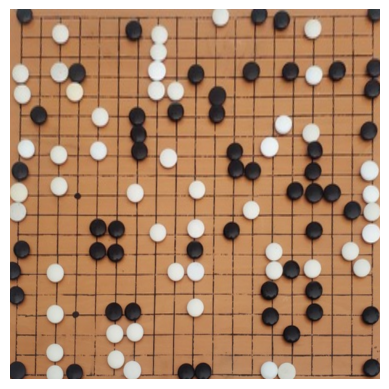

In [77]:
transformed_image_ = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

plt.imshow(transformed_image_)
plt.axis('off')  
plt.show()

Next, we're going to find the lines making up the board grid.
We start by fetching all the possible points that could help us identify lines, like empty intersections, empty edges and empty corners, and apply perspective transform. We then apply Kmeans algorithm to classify coordinates and group points who form one line; first we apply clustering on x-coordinates to find vertical lines, then on y-coordinates to find horizontal ones.

This automatically classifies lines into vertical and horizontal.

Next, we interpolate the lines to get complete lines having endpoints in the edges of the image, so that we can later calculate all intersections.

In [15]:
def adress_lines(lines):
    """
    Sort the order of endpoints

    Args:
    -----------
    lines: list
        list of lines unsorted
    
    Returns:
    --------
    list
        sorted lines    
    """
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i]
        if (x1 + y1) > (x2 + y2):
            x1, x2, y1, y2 = x2, x1, y2, y1
            lines[i] = x1, y1, x2, y2
    return lines

In [16]:
def lines_detection(model_results, perspective_matrix):
    """
    Process model results to identify and cluster all intersections.

    Args:
    -----------
    model_results : numpy.ndarray
                    List of model results containing information about boxes.
    perspective_matrix : numpy.ndarray
                    Perspective transformation matrix
    
    Returns:
    --------
    Tuple of two numpy.ndarrays representing clustered vertical and horizontal lines.
    """

    empty_intersections = model_results[0].boxes.xywh[model_results[0].boxes.cls == 3][:,[0, 1]]
    empty_corner = model_results[0].boxes.xywh[model_results[0].boxes.cls == 4][:,[0, 1]]
    empty_edge = model_results[0].boxes.xywh[model_results[0].boxes.cls == 5][:,[0, 1]]


    if not empty_intersections is None:
        if len(empty_intersections) != 0:
            empty_intersections = np.array(empty_intersections[:, [0, 1]])
            empty_intersections = cv2.perspectiveTransform(empty_intersections.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    if not empty_corner is None:
        if len(empty_corner) != 0:
            empty_corner = np.array(empty_corner[:, [0, 1]])
            empty_corner = cv2.perspectiveTransform(empty_corner.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    if not empty_edge is None:
        if len(empty_edge) != 0:
            empty_edge = np.array(empty_edge[:, [0, 1]])
            empty_edge = cv2.perspectiveTransform(empty_edge.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))

    all_intersections = np.concatenate((empty_intersections, empty_corner, empty_edge), axis=0)

    all_intersections = all_intersections[(all_intersections[:, 0:2] >= 0).all(axis=1) & (all_intersections[:, 0:2] <= 600).all(axis=1)]

    all_intersections = all_intersections[all_intersections[:, 0].argsort()]

    all_intersections_x = all_intersections[:,0].reshape((-1, 1))

    kmeans = KMeans(n_clusters=19, n_init=10)
    kmeans.fit(all_intersections_x)

    # Get the cluster labels for each line
    cluster_labels = kmeans.labels_
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    # Sort the labels based on their counts in decreasing order
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_unique_labels = unique_labels[sorted_indices]


    lines_equations = np.array([]).reshape((-1, 2))
    lines_points_length = np.array([])
    cluster_vertical = np.array([]).reshape((-1, 4))

    for i, label in enumerate(sorted_unique_labels):
        line = all_intersections[cluster_labels==label]
        # print(i, len(line), line)
        # draw_points(line.astype(int), img)
        if len(line) > 2:
            # line = line[np.argsort(line[:, 1])]
            slope, intercept = np.polyfit(line[:,1], line[:,0], 1) # on inverse x et y
            line_ = np.array([intercept, 0, slope * 600 + intercept, 600])# on iverse les x et y
            lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        else:
            if len(cluster_vertical) == 0:
                raise Exception(f">>>>>> Cannot reconstruct ALL VERTICAL LINES")
            elif len(line) < 1:
                raise Exception(f">>>>>> Cannot reconstruct vertical line at point {line}")
            else:
                x1, y1 = line[0]
                slope = np.average(lines_equations[:,0], weights=lines_points_length, axis=0)
                intercept = x1 - slope * y1
                line_ = np.array([intercept, 0, slope * 600 + intercept, 600])
                lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        lines_points_length = np.append(lines_points_length, [len(line)], axis=0)
        
        # x1, y1, x2, y2 = line_.astype(np.uint32)
        # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        # draw_points([(x1, y1), (x2, y2)], img)
        
        cluster_vertical = np.append(cluster_vertical, [line_], axis=0)
    cluster_vertical = adress_lines(cluster_vertical)
    cluster_vertical = np.sort(cluster_vertical, axis=0).astype(int)


    all_intersections = all_intersections[all_intersections[:, 1].argsort()]
    all_intersections_y = all_intersections[:,1].reshape((-1, 1))

    kmeans = KMeans(n_clusters=19, n_init=10)
    kmeans.fit(all_intersections_y)

    # Get the cluster labels for each line
    cluster_labels = kmeans.labels_
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    # Sort the labels based on their counts in decreasing order
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_unique_labels = unique_labels[sorted_indices]

    # img = np.copy(transformed_image)
    lines_equations = np.array([]).reshape((-1, 2))
    lines_points_length = np.array([])
    cluster_horizontal = np.array([]).reshape((-1, 4))

    for label in sorted_unique_labels:
        line = all_intersections[cluster_labels==label]
        
        if len(line) > 2:
            line = line[np.argsort(line[:, 0])]
            slope, intercept = np.polyfit(line[:,0], line[:,1], 1)
            line = np.array([0, intercept, 600, slope * 600 + intercept])
            lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        else:
            if len(cluster_horizontal) == 0:
                raise Exception(f">>>>>> Cannot reconstruct ALL HORIZONTAL LINES")
            elif len(line) < 1:
                raise Exception(f">>>>>> Cannot reconstruct line at point {line}")
            else:
                x1, y1 = line[0]
                slope = np.average(lines_equations[:,0], weights=lines_points_length, axis=0)
                intercept = y1 - slope * x1
                line = np.array([0, intercept, 600, slope * 600 + intercept])
                lines_equations = np.append(lines_equations, [[slope, intercept]], axis=0)
        lines_points_length = np.append(lines_points_length, [len(line)], axis=0)
        
        # x1, y1, x2, y2 = line.astype(int)
        # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        # draw_points([(x1, y1), (x2, y2)], img)
        cluster_horizontal = np.append(cluster_horizontal, [line], axis=0)
    cluster_horizontal = adress_lines(cluster_horizontal)
    cluster_horizontal = np.sort(cluster_horizontal, axis=0).astype(int)
 
    return np.array(cluster_vertical).reshape((-1, 4)), np.array(cluster_horizontal).reshape((-1, 4))

In [142]:
vertical_lines, horizontal_lines = lines_detection(results, perspective_matrix)

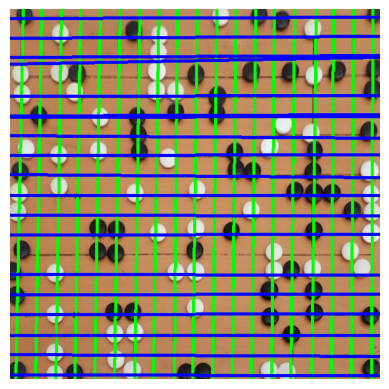

In [143]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=3)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Next, we have to clean the lines we interpolated to eliminate any duplicates.

In [21]:
def are_similar(line1, line2, threshold=10):
    """
    Compare two lines and decide if they're almost the same line based on a certain threshold

    Args:
    -----------
    line1: numpy.ndarray
        4 elements array representing the first line [x1, y1, x2, y2]
    line2: numpy.ndarray
        4 elements array representing the second line [x1, y1, x2, y2]
    threshold: int
        Smallest the difference between 2 lines (default is 10)
    
    Returns:
    --------
    bool
        true if similar, else false    
    """
    return np.all(np.abs(line1 - line2) <= threshold)

In [22]:
def removeDuplicates(lines):
    """
    Group similar lines and take the average of each group to keep one line per group

    Args:
    -----------
    lines: list
        list of lines to be filtered
    
    Returns:
    --------
    numpy.ndarray
        filtered list of lines   
    """
    grouped_lines = {}
    for line in lines:
        x1, y1, x2, y2 = line
        found = False
        for key in grouped_lines.keys():
            for element in grouped_lines[key]:
                if are_similar(element, line, threshold=15):
                    grouped_lines[key] = grouped_lines[key] + [line]
                    found = True
                    break
        if not found:
            grouped_lines[(x1, y1, x2, y2)] = [line]

    final_lines2 = []
    second_dict = {}
    for key in grouped_lines.keys():
        mean_line = np.mean(grouped_lines[key], axis=0).astype(dtype=int)
        final_lines2.append(mean_line)
        second_dict[tuple(mean_line)] = [mean_line]
    
    for line in lines:
        x1, y1, x2, y2 = line
        found = False
        for key in second_dict.keys():
            if are_similar(key, line, threshold=5):
                second_dict[key] = second_dict[key] + [line]
                found = True
                break
            
    final_lines = []
    for key in second_dict.keys():
        mean_line = np.mean(second_dict[key], axis=0).astype(dtype=int)
        final_lines.append(mean_line)
    
    return np.array(final_lines).astype(np.int32)

In [81]:
vertical_lines = removeDuplicates(vertical_lines)
horizontal_lines = removeDuplicates(horizontal_lines)

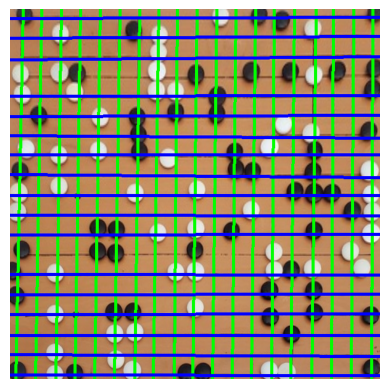

In [88]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=3)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

The duplicated line in the third row was removed.

Since not all the intersections will be detected, there will always be some missing lines on the grid. So we find the common distance between the lines so that we can add the missing lines in between lines with the correct spacing.

In [27]:
def calculate_distances(lines):
    """
    Calculate distances between consecutive lines.

    Args:
    -----------
    lines : numpy.ndarray
            Array of lines represented by coordinates [x1, y1, x2, y2].

    Returns:
    --------
    list : numpy.ndarray
            List of distances between consecutive lines.
    """
    distances = [(np.linalg.norm(lines[i + 1][:2]-lines[i][:2]) + np.linalg.norm(lines[i + 1][2:]-lines[i][2:])) / 2 for i in range(len(lines) - 1)]
    return distances

In [24]:
def find_common_distance(distances, target_distance=30):
    """
    Find the common distance among a set of distances using DBSCAN clustering.

    Args:
    -----------
    distances : list
                List of distances to be clustered and analyzed.
    target_distance : float, optional
                      The target distance to find among the clusters (default=30).

    Returns:
    --------
    Tuple
        Tuple containing the mean of the distances in the cluster with the target distance
        and the distances in that cluster.
    """
    
    # Reshape distances into a column vector
    distances_ = np.array(distances).reshape((-1, 1))

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=1, min_samples=1)
    labels = dbscan.fit_predict(distances_)
    
    means = np.array([])
    unique_labels = np.unique(labels)
    label_index = np.array([])
    
    # Calculate means for each cluster and store label and mean in arrays
    for label in unique_labels:
        means = np.append(means, np.mean(distances_[labels==label]))
        label_index = np.append(label_index, label)

    # Find the index of the cluster with the closest mean to the target distance
    index = np.argmin(np.abs(means - target_distance))
    
    # Return the mean of distances in the chosen cluster and the distances in that cluster
    return means[index], distances_[labels==label_index[index]]


In [25]:

def is_approx_multiple(value, base, threshold):
    """
    Check if a value is approximately a multiple of a given base within a specified threshold.

    Args:
    -----------
    value : float
            The value to check.
    base : float
           The base value for which the check is performed.
    threshold : float
                The maximum allowed deviation from being a multiple.

    Returns:
    --------
    bool
        True if the value is approximately a multiple of the base within the threshold, False otherwise.
    """
    return abs(value - math.floor(value / base) * base) < threshold

In [83]:
def is_vertical(x1, y1, x2, y2):
    """
    Decide if a line is vertical or not

    Args:
    -----------
    x1: float
        The start point of the line in X direction
    y1: float
        The start point of the line in Y direction
    x2: float
        The end point of the line in X direction
    y2: float
        The end point of the line in Y direction
    
    Returns:
    --------
    bool
        true if vertical, else false    
    """
    return abs(x1 - x2) < 50 and abs(y1 - y2) > 50


In [28]:
def restore_missing_lines(lines, distance_threshold=10):
    """
    Restore missing lines in a set of lines based on a common distance.

    Args:
    -----------
    lines : numpy.ndarray of shape (-1, 4)
            Array of lines represented by coordinates [x1, y1, x2, y2].
    distance_threshold : int, optional
                        Maximum threshold for spacing deviation to consider missing lines (default=10).

    Returns:
    --------
    numpy.ndarray
        Array of lines with restored missing lines.
    """
    # ax=0 : x axis / ax=1 : y axis
    lines = np.sort(lines, axis=0)
    distances = calculate_distances(lines)
    
    # If there are less than or equal to 1 distance, no restoration needed
    if len(distances) <= 1:
        return lines
    
    # Find mean distance and distances array after removing outliers
    mean_distance, distances = find_common_distance(distances)
    restored_lines = []
    
    for i in range(len(lines) - 1):
        spacing = (np.linalg.norm(lines[i + 1][:2]-lines[i][:2]) + np.linalg.norm(lines[i + 1][2:]-lines[i][2:]))/2
        
        if is_approx_multiple(spacing, mean_distance, distance_threshold):
            num_missing_lines = round(spacing / mean_distance) - 1
            
            for j in range(1, num_missing_lines + 1):
                if is_vertical(*lines[i]):
                    x1 = lines[i][0] + j * mean_distance
                    y1 = lines[i][1]
                    x2 = lines[i][2] + j * mean_distance
                    y2 = lines[i][3]
                else:
                    x1 = lines[i][0]
                    y1 = lines[i][1] + j * mean_distance
                    x2 = lines[i][2]
                    y2 = lines[i][3] + j * mean_distance
                restored_lines.append([x1, y1, x2, y2])
    
    # Append the restored lines to the original lines array
    if len(restored_lines) != 0:
        lines = np.append(lines, np.array(restored_lines, dtype=int), axis=0)
    
    # Sort the lines array
    lines = np.sort(lines, axis=0)
    
    return lines

In [90]:
vertical_lines = restore_missing_lines(vertical_lines)
horizontal_lines = restore_missing_lines(horizontal_lines)

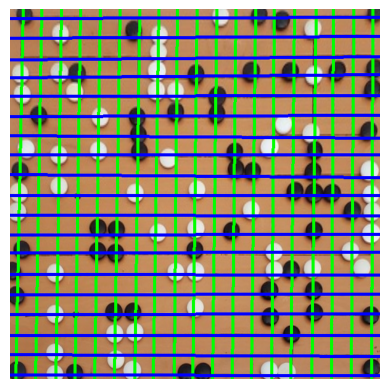

In [91]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=3)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Now we have all lines.

The previous algorithm doesn't restore lines in the edges, so we define a separate function to do that. We compare the first and the last line from each set (vertical and horizontal) its closest border to the average distance between the lines and add a line when necessary.

In our case, all lines in the edges were properly detected from the very begining.

In [92]:
def line_distance(line1, line2):
   x11, y11, x21, y21 = line1
   return (np.linalg.norm(line1[:2]-line2[:2]) + np.linalg.norm(line1[2:]-line2[2:])) / 2

In [30]:
def average_distance(lines):
    distances = [line_distance(lines[i + 1], lines[i]) for i in range(len(lines) - 1)]
    mean_distance = np.average(distances)
    return mean_distance

In [32]:
def add_lines_in_the_edges(lines, type):
    mean_distance = average_distance(lines)
    # print(mean_distance)

    if len(lines) != 18 and len(lines) != 17:
        return lines
    
    appended = False
    if type == "vertical":
        # 600 being the image size
        left_border =  np.array([0, 0, 0, 600])
        right_border = np.array([600, 0, 600, 600])
        if line_distance(lines[0], left_border) > mean_distance:
            x1 = lines[0][0]-mean_distance
            y1 = lines[0][1]
            x2 = lines[0][2]-mean_distance
            y2 = lines[0][3]
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
            appended = True
        if line_distance(lines[-1], right_border) > mean_distance:
            x1 = lines[-1][0]+mean_distance
            y1 = lines[-1][1]
            x2 = lines[-1][2]+mean_distance
            y2 = lines[-1][3]  
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
            appended = True
        lines = lines[lines[:, 0].argsort()]
            
        if not appended:
            print("No missing edges in the vertical lines")


    elif type == "horizontal":
        # 600 being the image size
        
        top_border =  np.array([0, 0, 600, 0])
        bottom_border = np.array([0, 600, 600, 600])
        if line_distance(lines[0], top_border) > mean_distance:
            x1 = lines[0][0]
            y1 = lines[0][1]-mean_distance
            x2 = lines[0][2]
            y2 = lines[0][3]-mean_distance
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)
            appended = True
        if line_distance(lines[-1], bottom_border) > mean_distance:
            x1 = lines[-1][0]
            y1 = lines[-1][1]+mean_distance
            x2 = lines[-1][2]
            y2 = lines[-1][3]+mean_distance   
            lines = np.append(lines, [[x1, y1, x2, y2]], axis=0)              
            appended = True
        
        lines = lines[lines[:, 1].argsort()]
            
        if not appended:
            print("No missing edges in the horizontal lines")
    else:
        print("Please specify a line type")
    

    return lines.astype(int)

In [93]:
vertical_lines = add_lines_in_the_edges(vertical_lines, "vertical")
horizontal_lines = add_lines_in_the_edges(horizontal_lines, "horizontal")

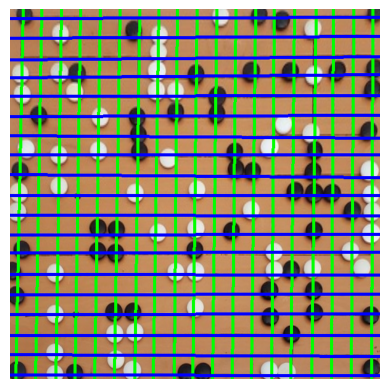

In [94]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=3)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Just in case, we apply again remove duplicates to make sure we don't have any overlapping lines after restoring missing ones.

In [34]:
vertical_lines = removeDuplicates(vertical_lines)
horizontal_lines = removeDuplicates(horizontal_lines)

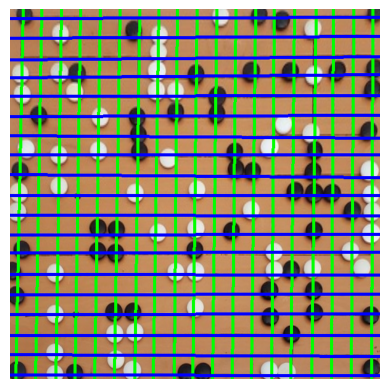

In [95]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=3)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Sometimes, we obtain some lines that are out of the image so we eliminate them.

In [98]:
cluster_1 = vertical_lines[(vertical_lines<=600).all(axis=1) & (vertical_lines>=0).all(axis=1)]
cluster_2 = horizontal_lines[(horizontal_lines<=600).all(axis=1) & (horizontal_lines>=0).all(axis=1)]

Given now all the lines making up grid, we can finally calculate all the 361 intersections on the board.

In [96]:
def line_equation(x1, y1, x2, y2):
    """
    Calculate the slope and the intercept b in the line equation y = slope * x + b

    Args:
    -----------
    x1: float
        The start point of the line in X direction
    y1: float
        The start point of the line in Y direction
    x2: float
        The end point of the line in X direction
    y2: float
        The end point of the line in Y direction
    
    Returns:
    --------
    float
        slope of the line
    float 
        intercept of the line 
    """
    if x1 == x2:
        "if slope is infinite , y = x1 = c"
        slope = float('Inf')
        b = x1
    else:
        slope = (y2-y1) / (x2-x1)
        b = y1 - slope * x1
    return slope, b

In [40]:
def intersect(line1, line2):
    """
    Find the intersection of 2 lines

    Args:
    -----------
    line1: list
        list of start point x, start point y, end point x, end point y
    line2: list
        list of start point x, start point y, end point x, end point y

    Returns:
    --------
    numpy.ndarray
        x and y coordinates of the intersection    
    """
    slope1, b1 = line_equation(*line1)
    slope2, b2 = line_equation(*line2)
    if slope1 == float('Inf'):
        x = b1
        y = slope2 * x + b2
    elif slope2 == float('Inf'):
        x = b2
        y = slope1 * x + b1
    else:
        x = (b2 - b1) / (slope1 - slope2)
        y = slope1 * x + b1
    return np.array([int(np.round(x)), int(np.round(y))])

In [39]:
def detect_intersections(cluster_1, cluster_2, image):
    """
    Detect intersections between vertical and horizontal line clusters.

    Args:
    -----------
    cluster_1 : numpy.ndarray
                Array of vertical lines represented by coordinates [x1, y1, x2, y2].
    cluster_2 : numpy.ndarray
                Array of horizontal lines represented by coordinates [x1, y1, x2, y2].
    image : numpy.ndarray
            Image array to define the boundary for intersection points.

    Returns:
    --------
    numpy.ndarray
        Array of intersection points between vertical and horizontal line clusters.
    """
    intersections = []
    
    for v_line in cluster_1:
        for h_line in cluster_2:
            inter = intersect(v_line, h_line)
            
            if all(image.shape[:1] > inter) and all(inter >= 0):
                intersections.append(tuple(inter.astype(dtype=int)))
    
    return np.array(intersections)

In [99]:
intersections = detect_intersections(cluster_1, cluster_2, transformed_image)

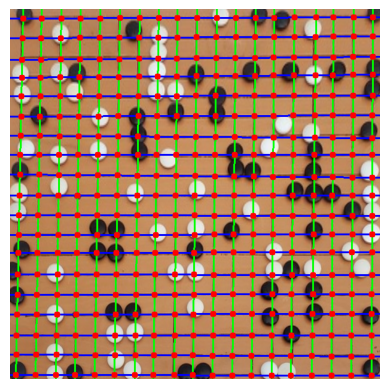

In [103]:
image = transformed_image.copy()

for line in vertical_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(0,255,0), thickness=2)

for line in horizontal_lines:
    cv2.line(image, (line[0], line[1]), (line[2], line[3]), color=(255,0,0), thickness=2)

for inter in intersections:
    cv2.circle(image, tuple(inter.astype(int)), 5, (0, 0, 255), thickness=-1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Next, we have to fetch the stones. For that, we only select detected stones inside the board and apply perspective transform.

In [35]:
def get_key_points(results, class_, perspective_matrix, output_edge=600):
    key_points = results[0].boxes.xywh[results[0].boxes.cls == class_]

    if not key_points is None:
        if len(key_points) != 0:
            key_points = np.array(key_points[:, [0, 1]])
            key_points_transf = cv2.perspectiveTransform(key_points.reshape((1, -1, 2)), perspective_matrix).reshape((-1, 2))
            return key_points_transf[(key_points_transf[:, 0:2] >= 0).all(axis=1) & (key_points_transf[:, 0:2] <= output_edge).all(axis=1)]

    return key_points

In [105]:
black_stones = get_key_points(results, 0, perspective_matrix)
white_stones = get_key_points(results, 6, perspective_matrix)

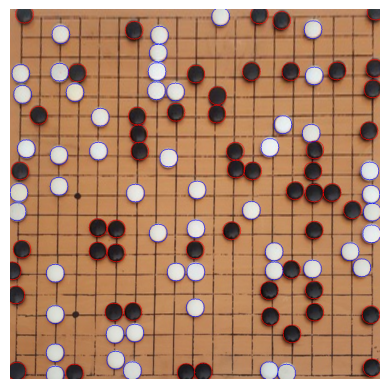

In [109]:
image = transformed_image.copy()

for stone in black_stones:
    cv2.circle(image, tuple(stone.astype(int)), 15, (0, 0, 255))

for stone in white_stones:
    cv2.circle(image, tuple(stone.astype(int)), 15, (255, 0, 0))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

Given the stones' coordinates and the intersections, we have to assign each stone to its correct position on the board. To do that, we fist create a dictionnary that represents the board where each key corresponds to the coordinates of one intersection and its value to its position on the board, ranging from (0,0) to (18,18).

In [41]:
def create_board(intersections, board_size=(19,19)):
    """
    Set up the board with 19x19=361 intersections 

    Args:
    -----------
    intersections: numpy.ndarray
        List of found and interpolated intersections
    board_size:
        Size of the board (default is 19x19)

    Returns:
    --------
    dict
        The board, in which each key correponds to an intersection and its value represents its coordinate on the board
        
    """

    sorted_indices = np.lexsort((intersections[:, 0], intersections[:, 1]))
    cleaned_intersections = intersections[sorted_indices]
    cleaned_intersections = cleaned_intersections.tolist()
    
    board = {}
    for j in range(0, 19):
        row = cleaned_intersections[:19]
        cleaned_intersections = cleaned_intersections[19:]
        row.sort(key=lambda x: x[0])
        # print(row)
        for i in range(19):
            if len(row) != 0:
                el = tuple(row.pop(0))
                board[el] = (i, j)
                # print(el, (i, j))
    
    return board

In [133]:
map = create_board(intersections)

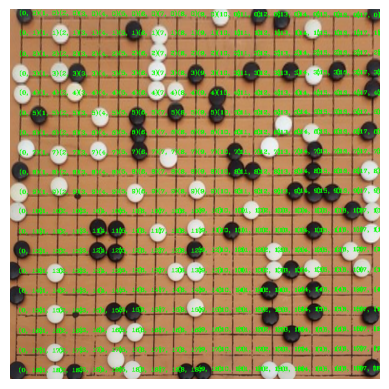

In [126]:
image = transformed_image.copy()

for key in map:
    if map[key] is not None:
        cv2.putText(image, f'{map[key]}', np.array(key).astype(int), fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL , fontScale=0.5, color=(0,255,0))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [134]:
def assign_stones(white_stones, black_stones, intersections):
    moves = []

    for stone in white_stones:
        nearest_corner = None
        closest_distance = 100000
        for inter in intersections:
            distance = math.dist(inter, stone)
            if distance < closest_distance:
                nearest_corner = tuple(inter)
                closest_distance = distance
        moves.append(("W", (map[nearest_corner][0], 18 - map[nearest_corner][1])))
        
            
    for stone in black_stones:       
        nearest_corner = None
        closest_distance = 100000
        for inter in intersections:
            distance = math.dist(inter, stone)
            if distance < closest_distance:
                nearest_corner = tuple(inter)
                closest_distance = distance
        moves.append(("B", (map[nearest_corner][0], 18 - map[nearest_corner][1])))
    return moves

In [135]:
moves = assign_stones(white_stones, black_stones, intersections)

In [127]:
moves

[('W', (14, 17)),
 ('W', (10, 2)),
 ('W', (10, 17)),
 ('W', (6, 2)),
 ('W', (2, 17)),
 ('W', (9, 9)),
 ('W', (2, 3)),
 ('W', (6, 17)),
 ('W', (14, 2)),
 ('B', (6, 12)),
 ('B', (6, 6)),
 ('B', (12, 17)),
 ('B', (8, 2)),
 ('B', (16, 17)),
 ('B', (12, 6)),
 ('B', (8, 17)),
 ('B', (4, 2)),
 ('B', (12, 12)),
 ('B', (4, 17)),
 ('B', (12, 2)),
 ('B', (16, 2))]

Now we have our moves, so we can create our sgf file and draw the corresponding board.

To create the sgf file, we defined the class GoSgf that initialize the sgf file, allows us to update the file move ny move or create the file with a list of ordered moves.

In [48]:
            
class GoSgf:
    """
    class GoSgf: 
    creates an sgf file given the list of moves (stones and their positions) extracted from the image recognition part
    """

    def __init__(self, black:str, white:str, tournament:str=None, date:str=None):
        """"
        Constructor method for GoSgf.

        Parameters:
        -----------
        black : str
            name of the black player
        white : str
            name of the white player
        moves : list
            a list of the played moves
        tournament : str
            tournament in which the game was played, can be attributed "training"
        date : str
            date in which the game was played
        """
        # define the game information
        self.black = black
        self.white = white
        self.board_size = (19,19)
        self.tournament = tournament

        self.game_info = {
            "EV" : tournament,
    	    "RO" : "1",
            #"GM" : "1", #game type, 1 for go
            "PB" : black,
            "PW" : white,
            #"SZ" : f"{self.board_size[0]}",
            "KM" : "6.5", #komi
            #"RU" : "Japanese" #rules used
            "DT" : date
        }

        #get the moves we collected from board recognition
        self.moves = []

    def update_sgf(self, move):
        """
        Add a move to the game and update the SGF file.

        Parameters:
        -----------
        player : str
            Player color ('B' for black, 'W' for white)
        position : tuple
            Tuple representing the (x, y) coordinates of the move
        """
        player, position = move
        self.moves.append((player, position))
        sgf_content = self.assembleSgf()

        sgf_filename = f"{self.black}_{self.white}.sgf"
        with open(sgf_filename, "w") as sgf_file:
            # Write game information
            sgf_file.write("(; \n")
            for key, value in self.game_info.items():
                sgf_file.write(f"{key}[{value}]\n")
            sgf_file.write("\n")

            # Write stone positions
            sgf_file.write(sgf_content)

            # End the SGF file
            sgf_file.write(")\n")
        
        return sgf_file, sgf_filename


    # ... (your existing methods)
    
    #convert a move to SGF format
    def add_to_sgf(self, move):
        """
        Add a move to the sgf file

        Returns:
        --------
        str
            one move composed of the player, the letter corresponding to the x coordinate, and the letter corresponding to the y coordinate
        """
        player, position = move
        x, y = position 
        sgf_x = chr(ord('a') + x)
        sgf_y = chr(ord('a') + y)
        return f";{player}[{sgf_x}{sgf_y}]"
        
    #convert the sgf file 
    def assembleSgf(self):
        """
        Put together and write the sgf file and save it

        Returns:
        --------
        sgf
            the sgf file of the game

        str
            The name of the sgf file
        """
        sgf_ = ''.join([self.add_to_sgf(move) for move in self.moves])
        return sgf_
    

    def createSgf(self, moves):
        """
        Create and Write the sgf file

        Returns:
        --------
        sgf_file : sgf
            the sgf file of the game
        sgf_filename : str
            name of the sgf file
        """
        self.moves = moves
        sgf_moves = self.assembleSgf()
        sgf_filename = f"{self.black}_{self.white}.sgf"
        
        with open(sgf_filename, "w") as sgf_file:

            # Write game information
            sgf_file.write("(; \n")
            for key, value in self.game_info.items():
                sgf_file.write(f"{key}[{value}]\n")
            sgf_file.write("\n")

            # Write stone positions
            sgf_file.write(sgf_moves)

            # End the SGF file
            sgf_file.write(")\n")

        return sgf_file, sgf_filename
    
    

In [136]:
fichier = GoSgf("player1", "player2")
sgf_file, sgf_filename = fichier.createSgf(moves)

Next, to draw the board, we defined the GoBoard class. It labels the last played move in red, and allows navigation in the sgf file, like accessing to the previous or the next positions

In [54]:
class GoBoard:
    """
    class Goboard: 
    creates a board given an sgf file provided by the GoSgf class
    can navigate through the game using methods such as previous or next
    """

    def __init__(self, sgf_url:str):
        """"
        Constructor method for GoBoard.

        Parameters:
        -----------
        sgf_url : str
            directory of the sgf file
        """
        with open(sgf_url, 'rb') as f:
            sgf_content = f.read()

        # Load an sgf file/ the game
        self.sgf_game = sgf.Sgf_game.from_bytes(sgf_content)
        
        #get the game size
        self.board_size = self.sgf_game.get_size()

        # Extract the game moves
        self.moves = []
        for node in self.sgf_game.get_main_sequence():
            color, move = node.get_move()
            if color is not None and move is not None:
                row, col = move
                self.moves.append((row, col, color)) 

        # Get the number of moves 
        self.total_number_of_moves = len(self.moves)

        # Define the current number of moves initialized by the total number, and which we'll modify each time whne calling the previus or the next fucntion
        self.current_number_of_moves = self.total_number_of_moves
        
       
    def drawBoard(self, number_of_moves_to_show : int):
        """
        Draw the board up to a certain number of moves

        Parameters:
        -----------
        number_of_moves_to_show : int
            Define moves we want to plot on the board

        Returns:
        --------
        numpy array
            The resulted board 
        """
        square_size = 30
        circle_radius = 12
        
        #set up the board's background
        board =np.full(((self.board_size+1)*square_size, (self.board_size+1)*square_size, 3), (69, 166, 245), dtype=np.uint8)
        board2 = np.zeros((self.board_size, self.board_size))

        #extract the moves we wanna show
        extracted_moves = self.moves[:number_of_moves_to_show]
        
        # Draw lines for the board grid
        
        # for i in range(board_size):
        #     ax.plot([i, i], [0, board_size - 1], color='k', linewidth = 0.7)
        #     ax.plot([0, board_size - 1], [i, i], color='k', linewidth = 0.7)
        
        for i in range(1, self.board_size+1):
            # Vertical lines and letters
            cv2.line(board, (square_size*i, square_size), (square_size*i, square_size*(self.board_size)), (0, 0, 0), thickness=1)
            #plt.text(i, -0.8, chr(97 + i), fontsize=8, color='black')    
            cv2.putText(board, str(i), (square_size*i, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=1)
            # Horizontal lines and letters
            cv2.line(board, (square_size, square_size*i), (square_size*(self.board_size), square_size*i), (0, 0, 0), thickness=1)
            #plt.text(-0.8, i, chr(97 + i), fontsize=8, color='black')  
            cv2.putText(board, str(i), (5, square_size*i), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=1)
        # Draw stones
        for move in extracted_moves:
            row, col, color = move
            if board2[row, col] == 0:
                stone_color = (0, 0, 0) if color == 'b' else (255, 255, 255)
                board2[row, col] = 1
                cv2.circle(board, ((col+1)*square_size, (row+1)*square_size), circle_radius, color=(66, 66, 66), thickness=2) # draw the edge
                cv2.circle(board, ((col+1)*square_size, (row+1)*square_size), circle_radius, color=stone_color, thickness=-1) # draw the stone
        
        #setting the contour of the last move to a different color
        last_move = extracted_moves[-1]           
        stone_color = (0,0,0) if last_move[2] == 'b' else (255, 255, 255)
        cv2.circle(board, ((last_move[1]+1)*square_size, (last_move[0] + 1)*square_size), circle_radius, color=(0,0,255), thickness=2) 
        cv2.circle(board, ((last_move[1]+1)*square_size, (last_move[0] + 1)*square_size), circle_radius, color=stone_color, thickness=-1) 

        return board

    
    
    def initial_position(self):
        """
        Display the initial position with the first move

        Returns:
        --------
        numpy array
            The resulted board drawn with only the first played move
        """
        self.current_number_of_moves = 1
        return self.drawBoard(1)

    def final_position(self):
        """
        Display the final position 

        Returns:
        --------
        numpy array
            The resulted board drawn with all the played moves 
        """
        self.current_number_of_moves = self.total_number_of_moves
        return self.drawBoard(self.total_number_of_moves)

    def current_position(self):
        """
        Display the current position

        Returns:
        --------
        numpy array
            The resulted board drawn with all the played moves up to the current instant
        """
        return self.drawBoard(self.current_number_of_moves)

    def current_turn(self):
        """
        Display whose turn to play

        Returns:
        --------
        string
            The color of the current turn
        """
        turn = self.moves[self.current_number_of_moves - 1][2]
        if turn == 'b':
            return 'White' 
        elif turn == 'w' or self.current_number_of_moves == 0:
            return 'black'
        
    def previous(self):
        """
        Display the previous position

        Returns:
        --------
        numpy array
            The board one move before the displayed position
        """
        if self.current_number_of_moves > 1:
            self.current_number_of_moves -= 1
            return self.drawBoard(self.current_number_of_moves)

    def next(self):
        """
        Display the next position

        Returns:
        --------
        numpy array
            The board one move after the displayed position
        """
        if self.current_number_of_moves < self.total_number_of_moves:
            self.current_number_of_moves += 1
            return self.drawBoard(self.current_number_of_moves)

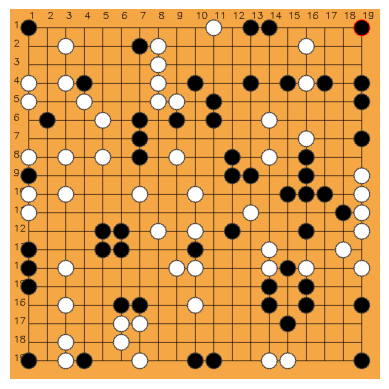

In [137]:
board = GoBoard(sgf_filename)
res = board.final_position()

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)
plt.axis('off') 
plt.show()

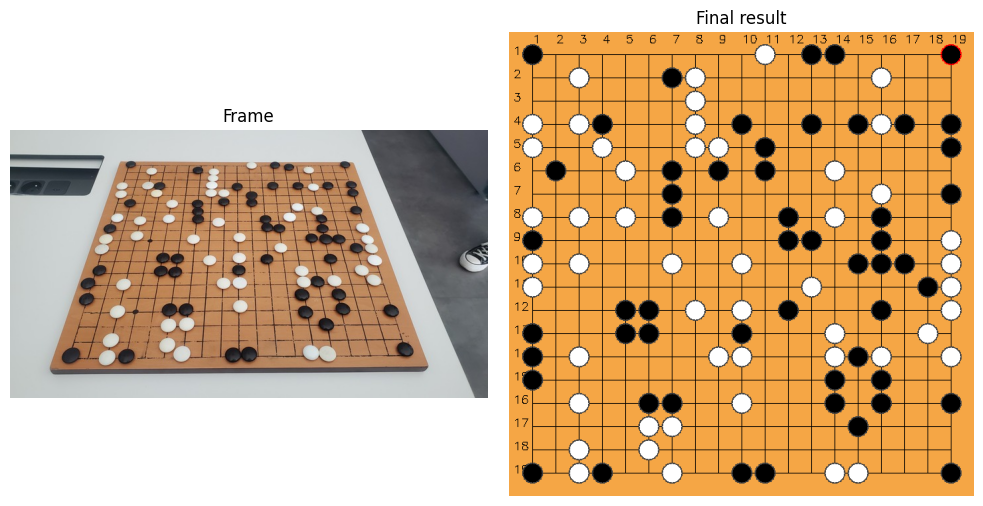

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the first subplot
axs[0].imshow(frame_)
axs[0].set_title('Frame')
axs[0].axis('off') 

# Plot on the second subplot
axs[1].imshow(res)
axs[1].set_title('Final result')
axs[1].axis('off') 

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()